In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import timeit
import scipy
import sys
import subprocess
from scipy.optimize import curve_fit
from typing import Callable

In [62]:
def generate_graph(v: int):
    graph = nx.generators.complete_graph(v)

    for (u,v,w) in graph.edges(data=True):
        w['weight'] = random.randint(0,10)

    return graph

In [85]:
graph = nx.generators.barbell_graph(3, 1)
# graph = nx.generators.complete_graph(5)

for (u,v,w) in graph.edges(data=True):
    w['weight'] = random.randint(0,10)

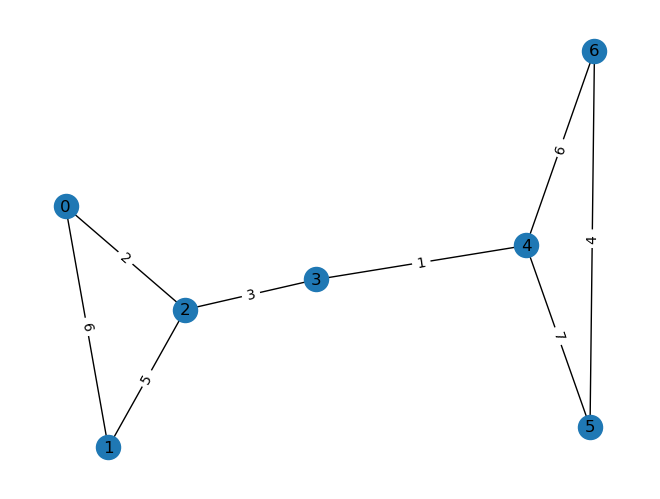

In [86]:
pos = nx.spring_layout(graph, seed=1)

nx.draw(graph, pos, with_labels=True)

edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.show()


Kruskal's algorithm

In [47]:
from typing import Any, Dict, Set

# A utility function to find set of an element i
# (truly uses path compression technique)
# union-find data structure maintains disjoint sets
def find(parent, i):
    if parent[i] != i:
        parent[i] = find(parent, parent[i])
    return parent[i]

def union(parent, rank, x, y):
    # need to attach an edgee to the tree with the most amount of edges
    if rank[x] < rank[y]:
        parent[x] = y
    elif rank[x] > rank[y]:
        parent[y] = x
    else:
        parent[y] = x
        rank[x] += 1

def kruskal_alg(graph):
    # set of edges in the tree
    A = []

    parent = {}
    rank = {}

    for v in graph.nodes():
        parent[v] = v
        rank[v] = 0

    # sort edges in increasing order by weight
    adjecency_list = {n: nbrdict for n, nbrdict in graph.adjacency()}
    sorted_edges = list(sorted(graph.edges(data=True), key=lambda t: t[2]['weight'])) 
    
    i = 0
    e = 0

    while e < len(graph.nodes()) - 1:
        u, v, w = sorted_edges[i]
        i += 1

        x = find(parent, u)
        y = find(parent, v)
        
        # making sure we don't get cycles
        if x != y:
            e = e + 1
            A.append((u, v))
            union(parent, rank, x, y)

    return A

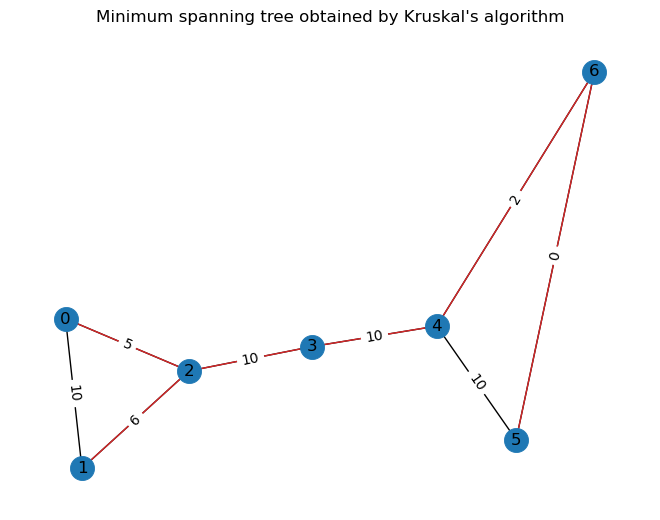

In [6]:
edges = kruskal_alg(graph)

mst = nx.Graph()
mst.update(edges=edges, nodes=graph.nodes.items())

nx.draw(graph, pos, with_labels=True, linewidths=0.6)

nx.draw_networkx_edges(graph, pos, edgelist=mst.edges(), edge_color="tab:red")

edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.title('Minimum spanning tree obtained by Kruskal\'s algorithm')

plt.show()

Prim's algorithm

In [7]:
# define the class Heap to use in Prim's algorithm
class Heap():
 
    def __init__(self):
        self.array = []
        self.size = 0
        self.pos = []
 
    def new_min_heap_node(self, v, dist):
        minHeapNode = [v, dist]
        return minHeapNode

    # utility function to swap two nodes of min heap
    def swap_min_heap_node(self, a, b):
        self.array[a], self.array[b] =  self.array[b], self.array[a]
    
    # function to heapify at given idx and also updates position of nodes when they are swapped
    def min_heapify(self, idx):
        smallest = idx
        left = 2 * idx + 1
        right = 2 * idx + 2
 
        if left < self.size and self.array[left][1] < \
                self.array[smallest][1]:
            smallest = left
 
        if right < self.size and self.array[right][1] < \
                self.array[smallest][1]:
            smallest = right
 
        
        if smallest != idx:

            self.pos[self.array[smallest][0]] = idx
            self.pos[self.array[idx][0]] = smallest
 
            self.swap_min_heap_node(smallest, idx)
            self.min_heapify(smallest)
 
    # function to extract minimum node from heap
    def extract_min(self):
 
        if self.is_empty() == True:
            return
 
        root = self.array[0]
 
        lastNode = self.array[self.size - 1]
        self.array[0] = lastNode
 
        self.pos[lastNode[0]] = 0
        self.pos[root[0]] = self.size - 1
 
        self.size -= 1
        self.min_heapify(0)
        return root
 
    def is_empty(self):
        return True if self.size == 0 else False
 
    def decrease_key(self, v, dist):
 
        i = self.pos[v]
        self.array[i][1] = dist

        # travel up while the complete tree is not heapified
        # this is a O(Logn) loop
        while i > 0 and self.array[i][1] < \
                self.array[(i - 1) // 2][1]:
 
            self.pos[self.array[i][0]] = (i-1)//2
            self.pos[self.array[(i-1)//2][0]] = i
            self.swap_min_heap_node(i, (i - 1)//2)
 
            i = (i - 1) // 2
 
    def is_in_min_heap(self, v):
        if self.pos[v] < self.size:
            return True
        return False


In [8]:
def prim_alg(graph):
    # set key values to infinity
    key = {v: sys.maxsize for v in graph.nodes()}

    parent = {v: None for v in graph.nodes()}
    parent[0] = -1
    
    # heap is initialized
    # minHeap represents set E
    Q = Heap()
    for v in graph.nodes():
        Q.array.append(Q.new_min_heap_node(v, key[v]))
        Q.pos.append(v)

    # key value of the root is zero
    key[0] = 0
    
    Q.decrease_key(0, key[0])
    
    Q.size = len(graph.nodes())
    
    visited = {v : False for v in graph.nodes()}
    visited[0] = True
    adjecency_list = {n: nbrdict for n, nbrdict in graph.adjacency()}
        
    while not Q.is_empty():

        v = Q.extract_min()
        v = v[0]
        
        visited[v] = True

        for u, w in adjecency_list[v].items():
            if not visited[u] and w['weight'] < key[u]:
                parent[u] = v
                key[u] = w['weight']
                Q.decrease_key(u, key[u])

    edges = []
    for i in range(1, len(graph.nodes())):
        edges.append((i, parent[i]))

    return edges

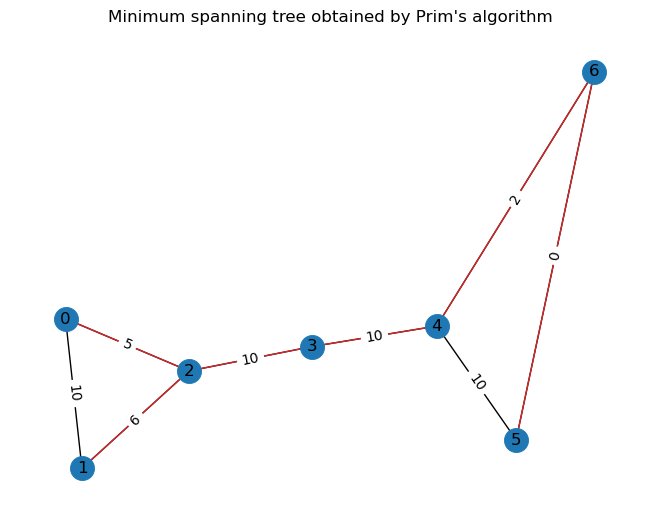

In [10]:
edges = prim_alg(graph)

mst = nx.Graph()
mst.update(edges=edges, nodes=graph.nodes.items())

nx.draw(graph, pos, with_labels=True, linewidths=0.6)

nx.draw_networkx_edges(graph, pos, edgelist=mst.edges(), edge_color="tab:red")

edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.title('Minimum spanning tree obtained by Prim\'s algorithm')

plt.show()

Time complexity analysis

In [20]:
def time_complexity_analysis(measured_function: Callable, data_generate_function: Callable, nodes_range):

    mean_execution_time = []

    for i in nodes_range:

        execution_time = []

        for j in range(2):

            data = data_generate_function(i)

            start = timeit.default_timer()
            measured_function(data)
            execution_time.append(timeit.default_timer() - start)
            
        mean_execution_time.append(np.mean(execution_time))
        
    return mean_execution_time


In [33]:
def time_complexity_analysis(measured_function: Callable, data_generate_function: Callable, nodes_range):

    mean_execution_time = []

    for i in nodes_range:

        execution_time = []

        for j in range(10):

            data = data_generate_function(i)

            start = timeit.default_timer()
            measured_function(data)
            execution_time.append(timeit.default_timer() - start)
            
        mean_execution_time.append(np.mean(execution_time))
        
    return mean_execution_time


In [34]:
def asymptotic_time_prim(v, a):
    e = v * (v - 1) / 2
    return a * (e * np.log(v)) 

In [35]:
def asymptotic_time_kruskal(v, a):
    e = v * (v - 1) / 2
    return a * e * np.log(v) 

In [48]:
v_num = np.arange(2, 95)
execution_time_kruskal = time_complexity_analysis(kruskal_alg, generate_graph, v_num, "kruskal")

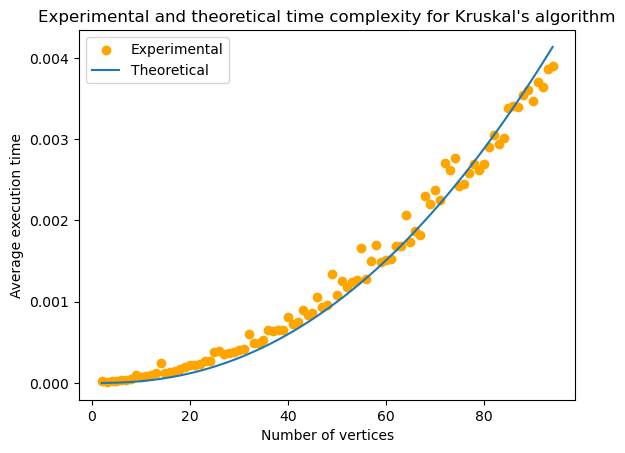

In [49]:
popt, _ = curve_fit(asymptotic_time_kruskal, v_num, execution_time_kruskal)
theoretical_execution_time_kruskal = asymptotic_time_kruskal(v_num, *popt)

plt.title('Experimental and theoretical time complexity for Kruskal\'s algorithm')
plt.scatter(v_num, execution_time_kruskal, c='orange', label='Experimental')
plt.plot(v_num, theoretical_execution_time_kruskal, label='Theoretical')
plt.ylabel('Average execution time')
plt.xlabel('Number of vertices')
plt.legend()

plt.show()

In [59]:
v_num = np.arange(2, 95)
execution_time_prim = time_complexity_analysis(prim_alg, generate_graph, v_num)

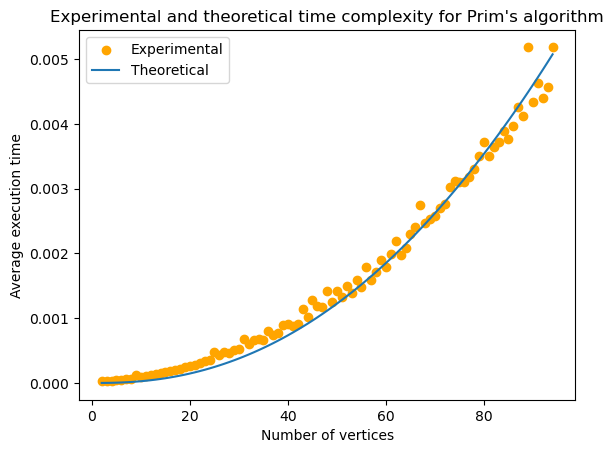

In [60]:
popt, _ = curve_fit(asymptotic_time_prim, v_num, execution_time_prim)
theoretical_execution_time_prim = asymptotic_time_prim(v_num, *popt)

plt.title('Experimental and theoretical time complexity for Prim\'s algorithm')
plt.scatter(v_num, execution_time_prim, c='orange', label='Experimental')
plt.plot(v_num, theoretical_execution_time_prim, label='Theoretical')
plt.ylabel('Average execution time')
plt.xlabel('Number of vertices')
plt.legend()

plt.show()

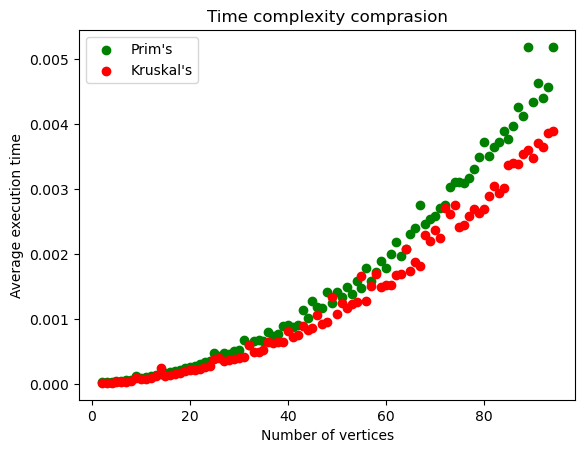

In [61]:
plt.title('Time complexity comprasion')
plt.scatter(v_num, execution_time_prim, c='green', label='Prim\'s')
plt.scatter(v_num, execution_time_kruskal, c='red', label='Kruskal\'s')
plt.ylabel('Average execution time')
plt.xlabel('Number of vertices')
plt.legend()

plt.show()